In this notebook, we will use LSTM to predict stock price (more precisely, we are interested in the rise and fall of a stock price based on previous information) in Keras. I will also use more than one feature in my model, and it could be interesting for you to see how we can create the LSTM input tw_1301 shape required by Keras in this case.

Moreover, we are going to implement a manual Grid Search to tune the hyperparameters. We will also take advantage of Early Stopping and Callback to reduce the hyperparameter tunning time. To the best of my knowledge, the tunned model has the best result on this tw_1301 in the Kaggle.

## Contents

* [Import Libraries and the tw_1301](#1)
* [Descriptive Analysis](#2)
    - [Number of unique stock symbols](#21)
    - [Choosing a Random Stock Symbol](#22)
    - [plotting Price through Time](#23)
    - [Fearure Scaling](#24)
    - [Creating LSTM input tw_1301](#25)
* [Train LSTM Model](#3)
* [Hyperparameter Tunning](#4)
    - [Introduction](#41)
    - [Grid Search](#42)
    - [Early Stopping and Callback](#43)
    - [Choosing the Best Model](#44)
* [Results](#5)

<a id="1"></a> <br>
## Import Libraries and the tw_1301

In [153]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os
import keras

for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./volume.png
./.DS_Store
./Kaggle-problem presentation.docx
./2330.TW(驗證).csv
./2330_TW.csv
./best_model.keras
./驗證用.csv
./台塑四寶2006_1_1~2024_04_01.zip
./stock-price-prediction-lstm-hyperparameter-tuning.ipynb
./stock-price-prediction-lstm-hyperparameter-tuning_tsmc.ipynb
./output.png
./data.png
./stock-price-prediction-lstm-hyperparameter-tuning_origin_result.ipynb
./1301.TW(驗證).csv
./Kaggle-problem presentation.pdf
./台塑四寶2006_1_1~2024_04_01/^TWII(台灣加權).csv
./台塑四寶2006_1_1~2024_04_01/1303.TW(南亞).csv
./台塑四寶2006_1_1~2024_04_01/6505.TW(台塑化).csv
./台塑四寶2006_1_1~2024_04_01/1301.TW(台塑).csv
./台塑四寶2006_1_1~2024_04_01/1326.TW(台化).csv
./2010.1.1~2024.4.1/^SOX(費城半導體).csv
./2010.1.1~2024.4.1/2330.TW(股息).csv
./2010.1.1~2024.4.1/TSM(ADR).csv
./2010.1.1~2024.4.1/2330.TW.csv
./.venv/pyvenv.cfg
./.venv/.gitignore
./.venv/bin/wheel3.11
./.venv/bin/import_pb_to_tensorboard
./.venv/bin/pyftsubset
./.venv/bin/markdown_py
./.venv/bin/jupyter-run
./.venv/bin/wheel3
./.venv/bin/activate.ps1
./.venv/bin/toco_fro

In [154]:
tw_1301 =  pd.read_csv('台塑四寶2006_1_1~2024_04_01/1301.TW(台塑).csv', header=0)
tw_1301 = tw_1301.dropna(axis=0, thresh=tw_1301.shape[1])
tw_1301.shape[1]

7

In [155]:
twll = pd.read_csv('台塑四寶2006_1_1~2024_04_01/^TWII(台灣加權).csv', header=0)
twll = twll.dropna(axis=0, thresh=twll.shape[1])
twll.shape[1]

7

<a id="2"></a> <br>
## Descriptive Analysis

In [156]:
tw_1301.head()

Date       Open       High        Low      Close  Adj Close  \
0  2006-01-02  44.059242  44.059242  43.710258  43.710258  17.729910   
1  2006-01-03  43.797504  44.408226  43.623013  44.408226  18.013023   
2  2006-01-04  44.757210  44.757210  44.146488  44.495472  18.048410   
3  2006-01-05  44.495472  44.757210  44.495472  44.669964  18.119188   
4  2006-01-06  44.844456  44.931702  44.146488  44.582718  18.083799   

       Volume  
0   6087383.0  
1   6323497.0  
2   7804366.0  
3  10166652.0  
4   9723078.0

In [157]:
twll.head()

Date         Open         High          Low        Close  \
0  2006-01-02  6457.609863  6492.919922  6424.029785  6462.060059   
1  2006-01-03  6476.200195  6591.770020  6457.089844  6591.770020   
2  2006-01-04  6658.319824  6670.959961  6579.660156  6616.439941   
3  2006-01-05  6669.799805  6717.120117  6666.839844  6709.870117   
4  2006-01-06  6757.410156  6761.009766  6676.649902  6694.819824   

     Adj Close     Volume  
0  6462.035645  4678400.0  
1  6591.745117  5181400.0  
2  6616.415039  5884200.0  
3  6709.844238  5822600.0  
4  6694.793945  5881400.0

In [158]:
print(tw_1301.columns)
print(tw_1301.shape)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
(4477, 7)


In [159]:
tw_1301.iloc[:, 2:-1].describe()

High          Low        Close    Adj Close
count  4477.000000  4477.000000  4477.000000  4477.000000
mean     80.695336    79.305088    80.056353    56.014415
std      18.090885    17.800109    17.971311    22.062503
min      38.281811    37.203449    37.517971    16.278957
25%      71.153847    69.800003    70.500000    39.848953
50%      79.900002    78.800003    79.400002    50.851871
75%      93.300003    92.019234    92.800003    77.366905
max     121.000000   116.500000   118.000000   104.023026

In [160]:
tw_1301.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4477 entries, 0 to 4481
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4477 non-null   object 
 1   Open       4477 non-null   float64
 2   High       4477 non-null   float64
 3   Low        4477 non-null   float64
 4   Close      4477 non-null   float64
 5   Adj Close  4477 non-null   float64
 6   Volume     4477 non-null   float64
dtypes: float64(6), object(1)
memory usage: 279.8+ KB


<a id="22"></a> <br>
## Choosing a Random Stock Symbol

In [161]:
tw_1301_prices = tw_1301.reset_index(drop = True)
tw_1301_prices.iloc[:10, :]

Date       Open       High        Low      Close  Adj Close  \
0  2006-01-02  44.059242  44.059242  43.710258  43.710258  17.729910   
1  2006-01-03  43.797504  44.408226  43.623013  44.408226  18.013023   
2  2006-01-04  44.757210  44.757210  44.146488  44.495472  18.048410   
3  2006-01-05  44.495472  44.757210  44.495472  44.669964  18.119188   
4  2006-01-06  44.844456  44.931702  44.146488  44.582718  18.083799   
5  2006-01-09  44.582718  44.669964  44.233734  44.408226  18.013023   
6  2006-01-10  44.408226  44.669964  44.146488  44.669964  18.119188   
7  2006-01-11  44.669964  45.716919  44.495472  45.716919  18.543863   
8  2006-01-12  45.804165  46.414886  45.455177  45.978657  18.650026   
9  2006-01-13  46.065903  46.240395  45.716919  45.804165  18.579248   

       Volume  
0   6087383.0  
1   6323497.0  
2   7804366.0  
3  10166652.0  
4   9723078.0  
5   8570017.0  
6   5549822.0  
7  26317530.0  
8  38958794.0  
9  10960957.0

In [162]:
twll_prices =twll.reset_index(drop = True)
twll_prices.iloc[:10, :]

Date         Open         High          Low        Close  \
0  2006-01-02  6457.609863  6492.919922  6424.029785  6462.060059   
1  2006-01-03  6476.200195  6591.770020  6457.089844  6591.770020   
2  2006-01-04  6658.319824  6670.959961  6579.660156  6616.439941   
3  2006-01-05  6669.799805  6717.120117  6666.839844  6709.870117   
4  2006-01-06  6757.410156  6761.009766  6676.649902  6694.819824   
5  2006-01-09  6752.089844  6763.859863  6708.589844  6742.390137   
6  2006-01-10  6751.560059  6751.560059  6678.839844  6707.399902   
7  2006-01-11  6702.470215  6741.919922  6650.609863  6735.890137   
8  2006-01-12  6782.149902  6797.200195  6725.569824  6725.609863   
9  2006-01-13  6729.580078  6729.580078  6669.640137  6682.350098   

     Adj Close     Volume  
0  6462.035645  4678400.0  
1  6591.745117  5181400.0  
2  6616.415039  5884200.0  
3  6709.844238  5822600.0  
4  6694.793945  5881400.0  
5  6742.364258  5345200.0  
6  6707.374023  4453600.0  
7  6735.864258  5109000.0  
8  6725.583984  5927800.0  
9  6682.324707  3789200.0

In [163]:
tw_1301_dates = tw_1301_prices.loc[:, "Date"].to_list()
twll_dates = twll_prices.loc[:, "Date"].to_list()
dates = list(set(tw_1301_dates) & set(twll_dates))
dates.sort()

values = tw_1301_prices.values
print(values)
for d in range(0, len(values)):
    if not values[d][0] in dates:
        tw_1301_prices = tw_1301_prices.drop(d)

values = twll_prices.values
print(values)
for d in range(0, len(values)):
    if not values[d][0] in dates:
        twll_prices = twll_prices.drop(d)
print(values)
for d in range(0, len(values)):
    if not values[d][0] in dates:
        sox_prices = sox_prices.drop(d)

[['2006-01-02' 44.059242 44.059242 ... 43.710258 17.72991 6087383.0]
 ['2006-01-03' 43.797504 44.408226 ... 44.408226 18.013023 6323497.0]
 ['2006-01-04' 44.75721 44.75721 ... 44.495472 18.04841 7804366.0]
 ...
 ['2024-03-27' 69.199997 69.199997 ... 68.5 68.5 4920805.0]
 ['2024-03-28' 68.5 68.599998 ... 68.099998 68.099998 4279439.0]
 ['2024-03-29' 68.5 69.300003 ... 69.099998 69.099998 4947000.0]]
[['2006-01-02' 6457.609863 6492.919922 ... 6462.060059 6462.035645
  4678400.0]
 ['2006-01-03' 6476.200195 6591.77002 ... 6591.77002 6591.745117
  5181400.0]
 ['2006-01-04' 6658.319824 6670.959961 ... 6616.439941 6616.415039
  5884200.0]
 ...
 ['2024-03-27' 20158.070313 20255.099609 ... 20200.119141 20200.119141
  3865800.0]
 ['2024-03-28' 20213.339844 20222.199219 ... 20146.550781 20146.550781
  4294000.0]
 ['2024-03-29' 20156.339844 20335.919922 ... 20294.449219 20294.449219
  4231500.0]]
[['2006-01-02' 6457.609863 6492.919922 ... 6462.060059 6462.035645
  4678400.0]
 ['2006-01-03' 6476.20

In [164]:
tw_1301_dates = tw_1301_prices.loc[:, "Date"].to_list()
twll_dates = twll_prices.loc[:, "Date"].to_list()
tw_1301_dates == twll_dates == dates

True

In [165]:
tw_1301_prices = tw_1301_prices.drop(['Date'], axis=1)

In [166]:
twll_prices = twll_prices.drop(['Date'], axis=1)

<a id="23"></a> <br>
## plotting Price through Time

While the first big plot shows opening, closing, low, and high price altogether, the following four plots show each attribute separately. It may seem that all of the mentioned prices are the same, but as it is clear in the first big plot, they have a slight difference with each other.

/var/folders/03/5d5y4yvs4sz5w5h3x8jcq_w40000gn/T/ipykernel_8119/3975930980.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')
/var/folders/03/5d5y4yvs4sz5w5h3x8jcq_w40000gn/T/ipykernel_8119/3975930980.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


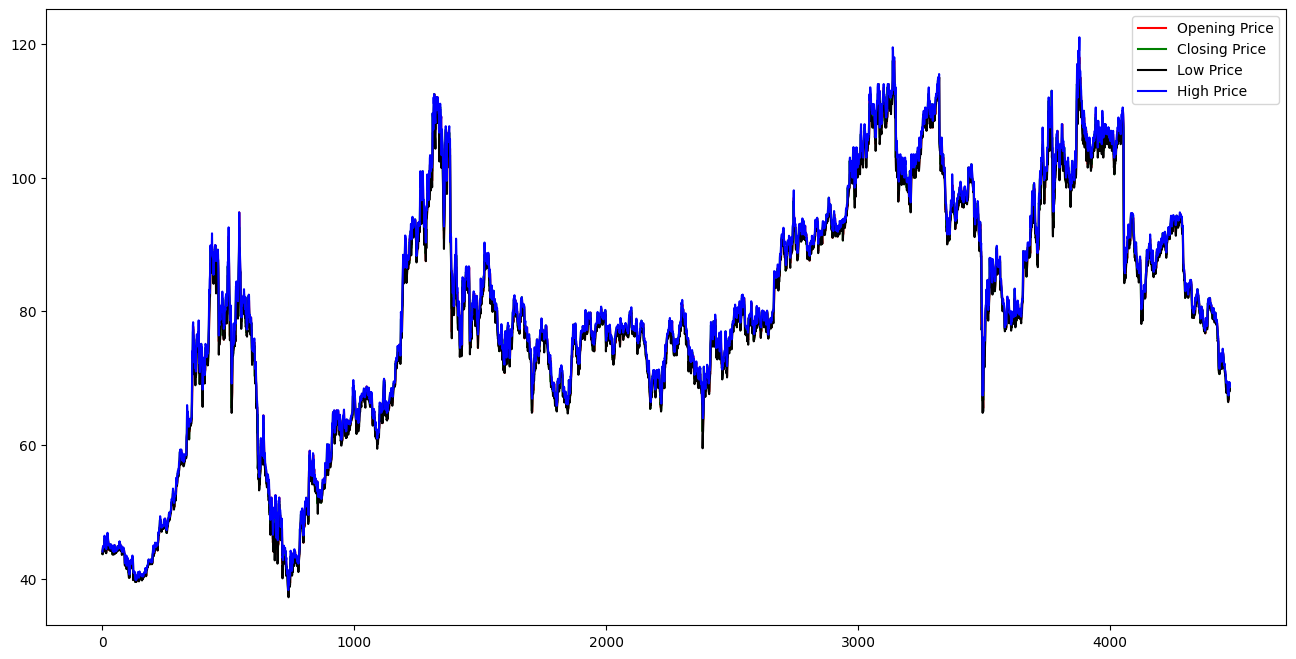

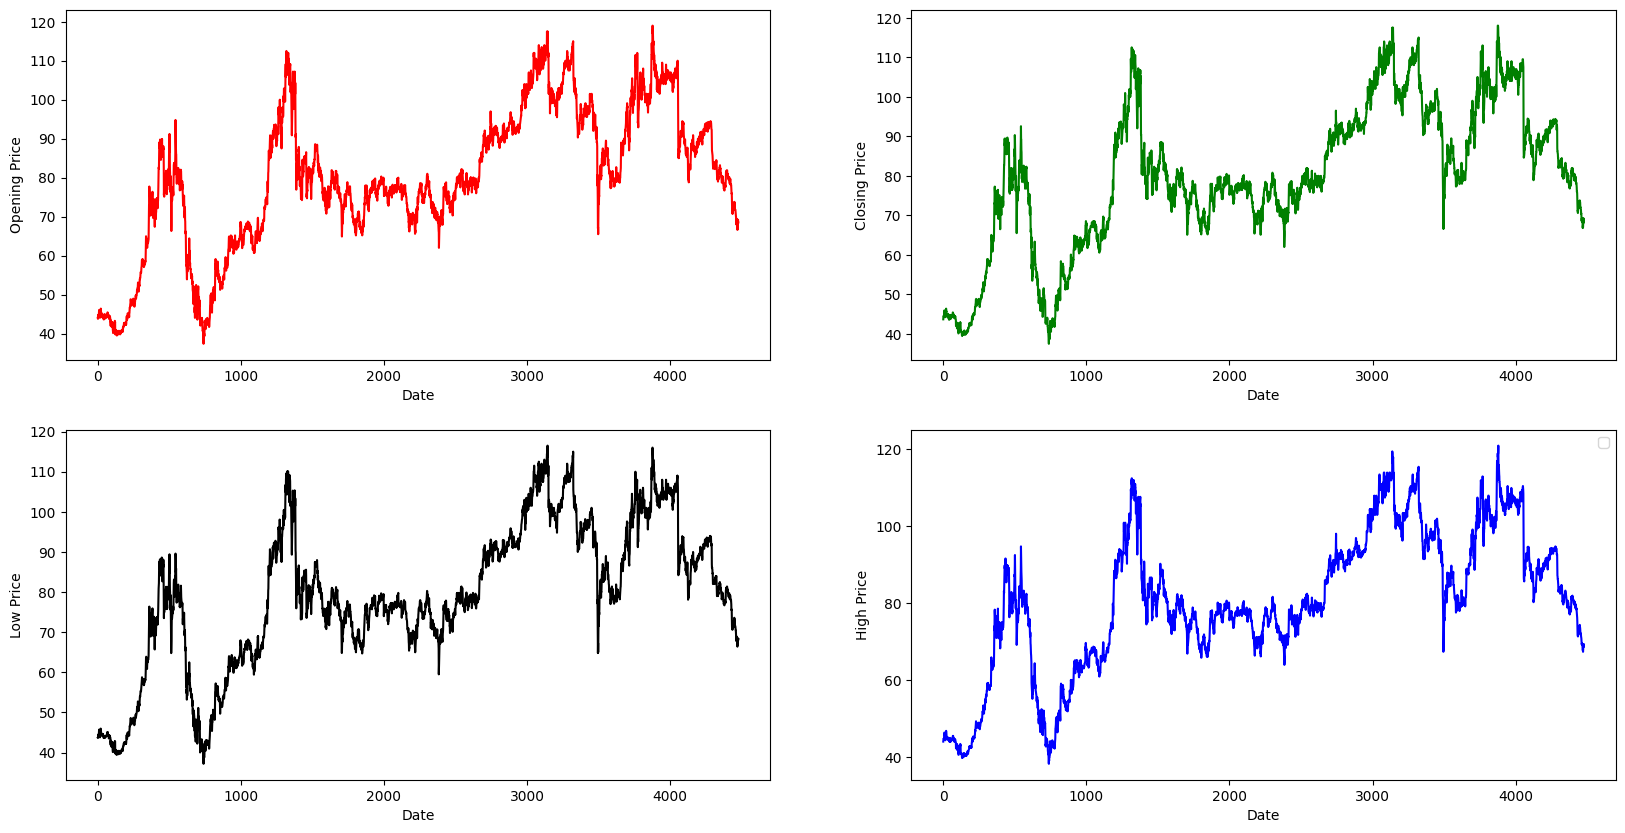

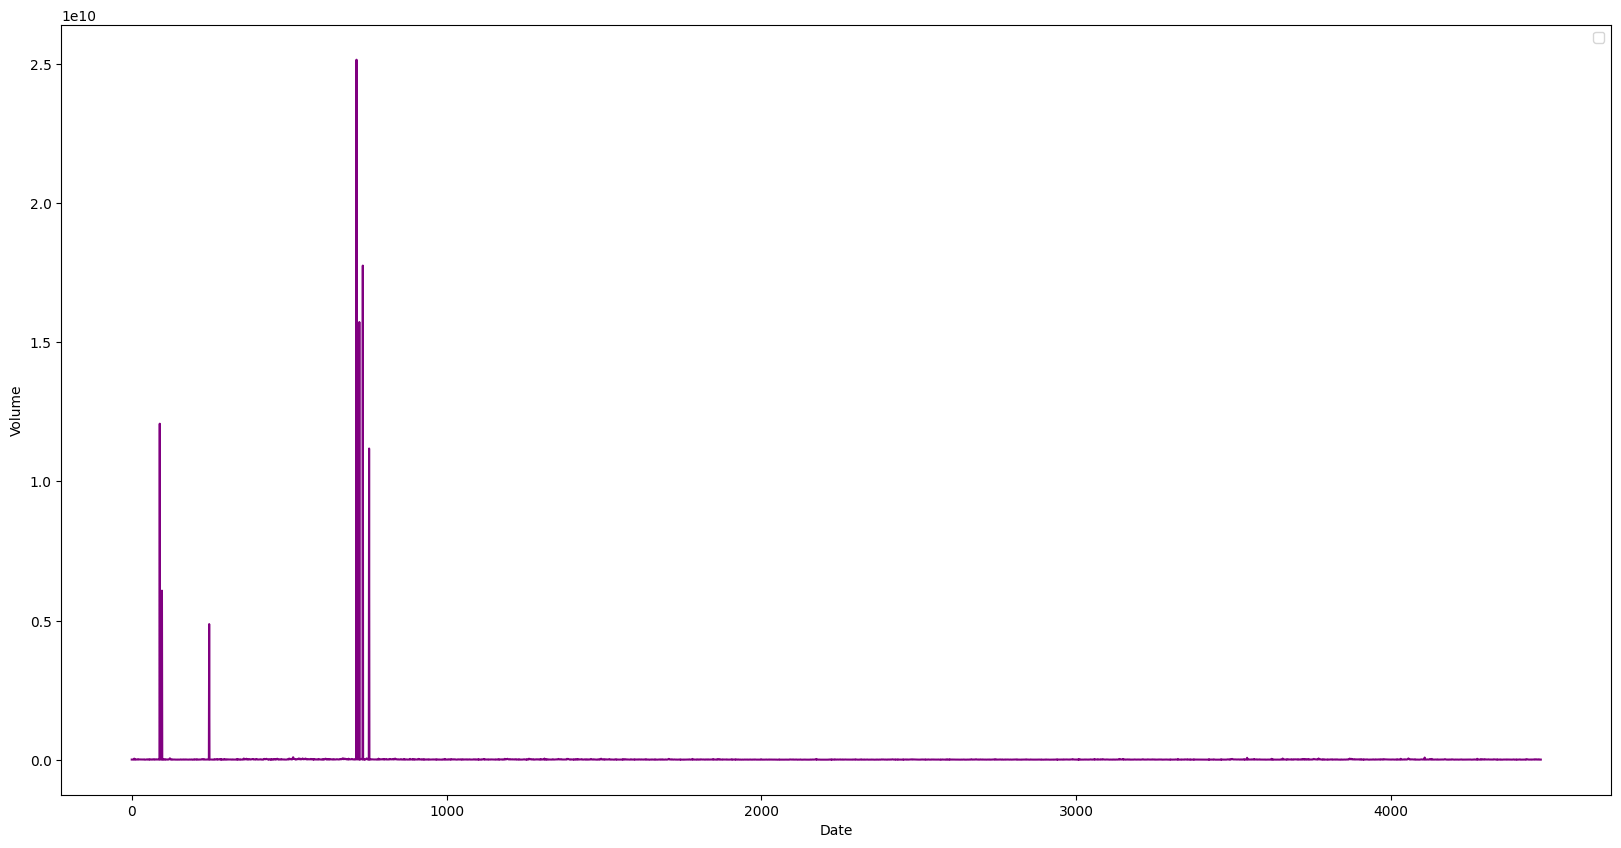

In [167]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(tw_1301_prices['Open'], color='red', label = 'Opening Price')
plt.plot(tw_1301_prices['Close'], color='green', label = 'Closing Price')
plt.plot(tw_1301_prices['Low'], color='black', label = 'Low Price')
plt.plot(tw_1301_prices['High'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(tw_1301_prices['Open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(tw_1301_prices['Close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(tw_1301_prices['Low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(tw_1301_prices['High'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend(loc='best')

plt.figure(figsize=(20, 10))
plt.plot(tw_1301_prices["Volume"], color="purple")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend(loc="best")

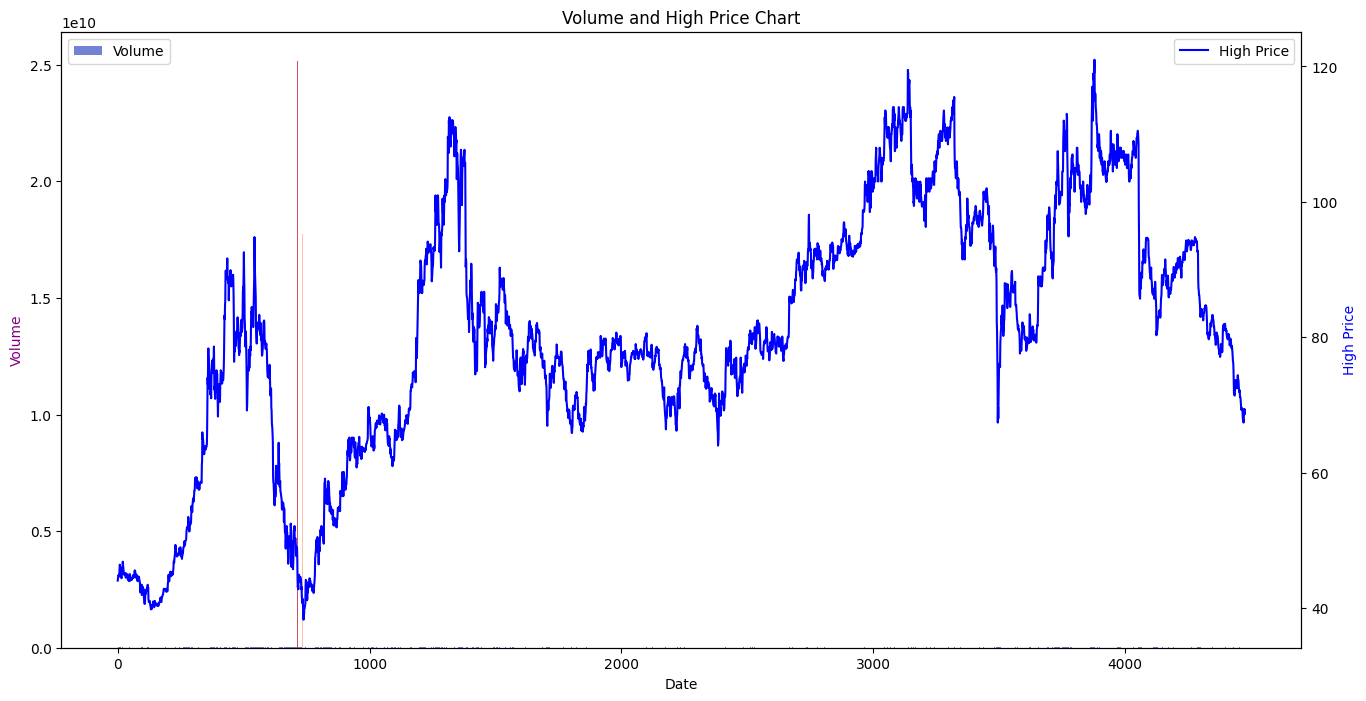

In [168]:
import matplotlib.pyplot as plt
import numpy as np

dates = tw_1301_prices.index
volumes = tw_1301_prices['Volume']
high_prices = tw_1301_prices['High']

color_map = plt.get_cmap('coolwarm') 
norm = plt.Normalize(volumes.min(), volumes.max())

fig, ax1 = plt.subplots(figsize=(16, 8))

bar_colors = color_map(norm(volumes))
bars = ax1.bar(dates, volumes, color=bar_colors, label='Volume', alpha=0.7)


sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])
# cbar = plt.colorbar(sm)
# cbar.set_label('Volume')

ax2 = ax1.twinx()
ax2.plot(dates, high_prices, color='blue', label='High Price')


ax1.set_xlabel('Date')
ax1.set_ylabel('Volume', color='purple')
ax2.set_ylabel('High Price', color='blue')
plt.title('Volume and High Price Chart')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


We choose the opening price and volume as two attributes to consider in our model.

In [169]:
tw_1301_prices = tw_1301_prices.drop(['Close', 'Low', 'High', "Adj Close"], axis=1)

In [170]:
twll_prices = twll_prices.drop(['Close', 'Low', 'High', "Adj Close", "Volume"], axis=1)

In [171]:
tw_1301_prices = tw_1301_prices.reset_index()
twll_prices = twll_prices.reset_index()

In [172]:
print(tw_1301_prices.index)
print(twll_prices.index)
tw_1301_prices.index.all() == twll_prices.index.all()

RangeIndex(start=0, stop=4465, step=1)
RangeIndex(start=0, stop=4465, step=1)


True

In [173]:
twll_prices = twll_prices.rename({"Open": "twll Open"}, axis=1)
data = pd.concat([tw_1301_prices, twll_prices], axis=1, join="outer")
data = data.drop(["index"], axis=1)
data

Open      Volume     twll Open
0     44.059242   6087383.0   6457.609863
1     43.797504   6323497.0   6476.200195
2     44.757210   7804366.0   6658.319824
3     44.495472  10166652.0   6669.799805
4     44.844456   9723078.0   6757.410156
...         ...         ...           ...
4460  66.900002   4599950.0  20228.640625
4461  67.900002  10158477.0  20208.880859
4462  69.199997   4920805.0  20158.070313
4463  68.500000   4279439.0  20213.339844
4464  68.500000   4947000.0  20156.339844

[4465 rows x 3 columns]

<a id="24"></a> <br>
## Fearure Scaling

In [121]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
data_scaled = sc.fit_transform(data)

In [122]:
print(data_scaled.shape)

(4465, 3)


<a id="25"></a> <br>
## Creating LSTM input tw_1301

In order to use LSTM, our input and output tw_1301 should have a specific shape. It was a bit complicated for me when I was first introduced to LSTM, but I found [this](https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e) comprehensive article to fully understand what was going on. In a nutshell, the input and output tw_1301 in an LSTM model is a three-dimensional array where the first dimension represents **the number of samples (or batch size)** like the number of rows of tw_1301 in a two-dimensional setting, the second dimension stands for **time steps** which indicates the amount of time that we want to go back through time, and the third dimension shows **the number of features (or input dimension)** that we want to include in the model for every element in our batch. So, it is like [number_of_samples, time_steps, input_dim]. The below image is retrieved from the mentioned article and could be a good illustration of the LSTM input and output tw_1301 shape.
![](https://miro.medium.com/max/665/1*AQKRJsRdWx2HZ85H1yWoKw.png)

Sometimes we prefer to choose the validation set by ourselves. In this case, in the below code, you can pass a value in the range of (0, 1) for the validation_split_percentage when you are calling the create_tw_1301 function, and use the below code to fit the model:

- model.fit(train_X, train_y, validation_tw_1301=(val_x, val_y))  # manually splitting

In my case, I rathered to use the built-in parameter (validation_split) in the fit method of the Keras library.  It considers a fraction of the training tw_1301 as the validation set to evaluate loss and metrics at the end of each epoch as follow:

- model.fit(train_X, train_y, validation_split=0.3)  # automatically splitting

Here, at each point of the time, we will consider price and volume as our attributes in input_dim, and 25 days as our time_steps.

In [174]:
# Creating a tw_1301 structure (it does not work when you have only one feature)
def create_tw_1301(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_tw_1301, y_tw_1301 = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_tw_1301.append(df[i - n_past:i, 0:n_feature])
        y_tw_1301.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_tw_1301)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_tw_1301[:split_train_validation_starting_point]
    y_train = y_tw_1301[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_tw_1301[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  y_tw_1301[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_tw_1301[split_training_test_starting_point:]
    y_test = y_tw_1301[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [175]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_tw_1301(data_scaled, n_future=5, n_past=5, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [176]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3565, 5, 3)
(0,)
(891, 5, 3)
(3565, 1)
(0,)
(891, 1)


<a id="4"></a> <br>
## Hyperparameter Tunning


We have two important terms in machine learning referred to as **model parameter** and **model hyperparamer**. So, first of all, what is a hyperparameter, and what is a parameter? Based on [here](https://www.tw_1301camp.com/community/tutorials/parameter-optimization-machine-learning-models),

- A model **model hyperparameter** is a configuration that is external to the model and whose value cannot be estimated from the tw_1301 and a **model parameter** is a configuration variable that is internal to the model and whose value can be estimated from the given tw_1301.

In the other words, a hyperparameter is used to construct the structure of the model and cannot be learned from the tw_1301 and its value is set before the learning process begins. Therefore, hyperparameters are like the settings of an algorithm that can be adjusted to optimize performance and prevent overfitting. This is exactly what we do in the hyperparameter tuning. We try to choose a set of optimal hyperparameters for a learning algorithm to enhance the performance of the model. There are two frequently used methods to perform hyperparameter tunning called 1)Grid Search and 2)Random Search. In this notebook, I have used the former one because of its simplicity to implement and at the same time, its powerful performance. More information on both of the methods can be found in [here](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85).

<a id="42"></a> <br>
## Grid Search

Grid search is a traditional method to perform hyperparameter tunning. It basically works by defining a subset of candidate values for each hyperparameter, and training all the possible combination of the hyperparameters. Then, each possible fitted model is evaluated on a validation set, and the best configuration of the hyperparameter will be choosed at the end.

<a id="43"></a> <br>
## Early Stopping and Callback

Since in the Grid Search, we have to train an LSTM model for each combination, it may take so much time to fit all the models and choose the best combination of the hyperparameters. One of the ways that we can prevent this from happening is through using Early Stopping and Callbacks. The idea here is to track a measure (like validation loss) and whenever a stopping criterion (like no improvement in the monitored measure value in successive steps, reaching a pre-specified limit for that measure, or a pre-specified increment in that measure) is satisfied, we can stop the training process. The measure that we are using here is validation loss since the validation set is not used in the training process. [This](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) article is one of the best articles that I've read about using Early Stopping to halt the training of a model at the right time. In the below, I copied and pasted the parts that I found important:

> 1. **es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)** ****-->**** Often, the first sign of no further improvement may not be the best time to stop training. This is because the model may coast into a plateau of no improvement or even get slightly worse before getting much better. We can account for this by adding a delay to the trigger in terms of the number of epochs on which we would like to see no improvement. This can be done by setting the “patience” argument.
    
> 2. **es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)** **-->** By default, any change in the performance measure, no matter how fractional, will be considered an improvement. You may want to consider an improvement that is a specific increment, such as 1 unit for mean squared error or 1% for accuracy. This can be specified via the “min_delta” argument.

> 3. **es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4)** **-->**  Finally, it may be desirable to only stop training if performance stays above or below a given threshold or baseline. For example, if you have familiarity with the training of the model (e.g. learning curves) and know that once a validation loss of a given value is achieved that there is no point in continuing training. This can be specified by setting the “baseline” argument.
    
> 4. **mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)** **-->** The EarlyStopping callback will stop training once triggered, but the model at the end of training may not be the model with best performance on the validation tw_1301set. An additional callback is required that will save the best model observed during training for later use. This is the ModelCheckpoint callback.

In [180]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=5, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        '''''
        From the mentioned article above --> If a validation tw_1301set is specified to the fit() function via the validation_tw_1301 or v
        alidation_split arguments,then the loss on the validation tw_1301set will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.keras'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        history = regressor.fit(x_train, y_train, validation_split=0.3, epochs=10, batch_size=n_batch_size, callbacks=[mc],verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy, history)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [181]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------


/Users/patten/my_files/大學課業/大三/資料探勘/project/DataMining-Stock-main/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00206, saving model to best_model.keras

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss improved from 0.00206 to 0.00161, saving model to best_model.keras

Epoch 5: val_loss did not improve from 0.00161

Epoch 6: val_loss improved from 0.00161 to 0.00144, saving model to best_model.keras

Epoch 7: val_loss did not improve from 0.00144

Epoch 8: val_loss did not improve from 0.00144

Epoch 9: val_loss did not improve from 0.00144

Epoch 10: val_loss did not improve from 0.00144
0-th combination = (False, False, False, 16, 8, 0.2) 
 train accuracy: [0.0014722474152222276, 0.03836987540125847] and test accuracy: [0.0019385135965421796, 0.04402855411171913]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
----------------------

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])
dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])
dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])
dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])
dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])
dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


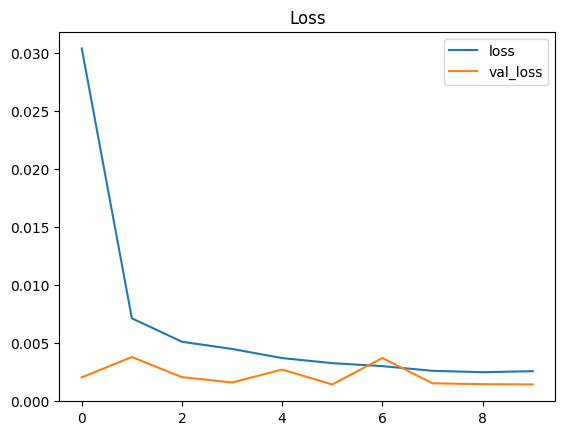

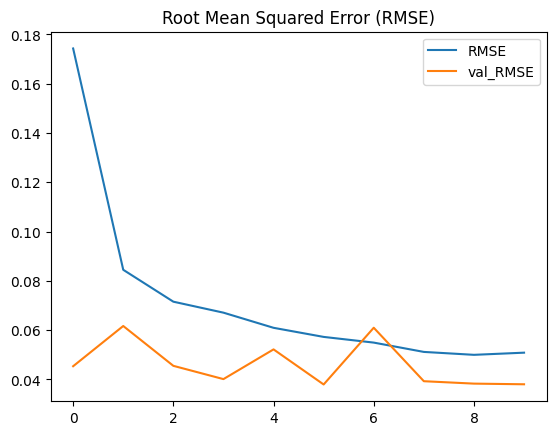

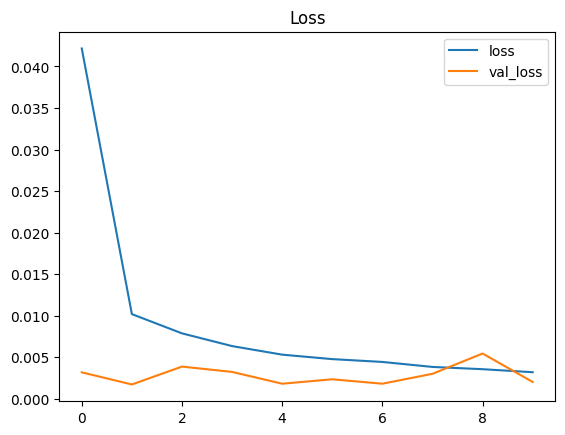

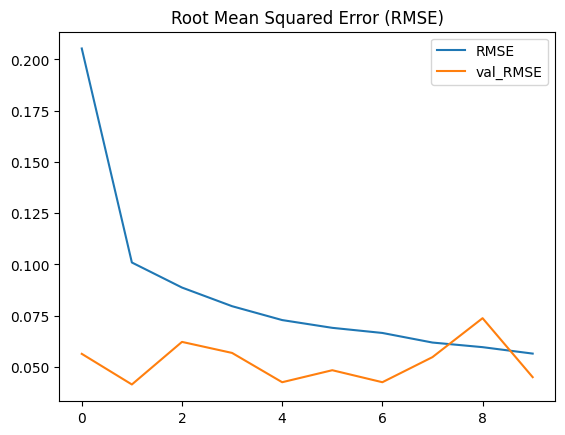

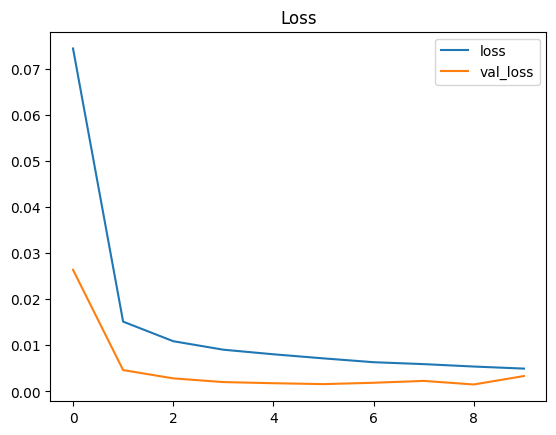

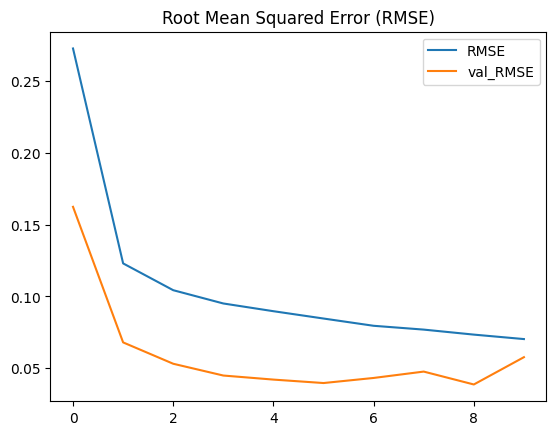

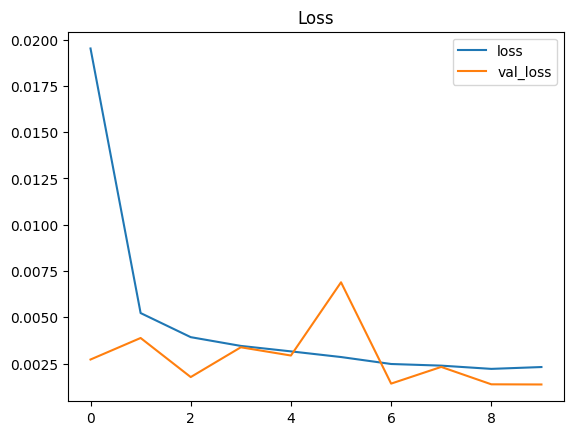

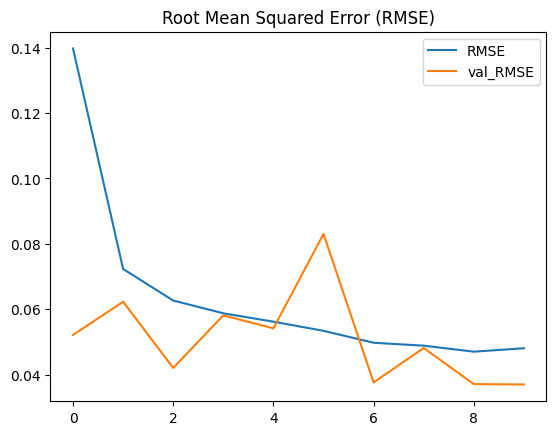

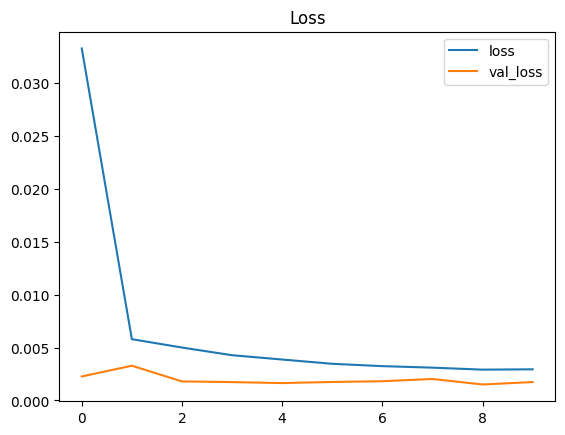

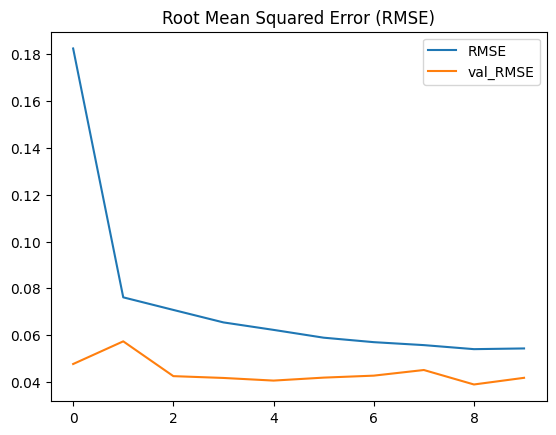

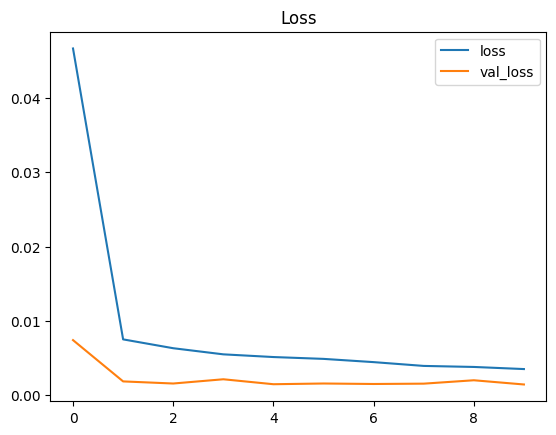

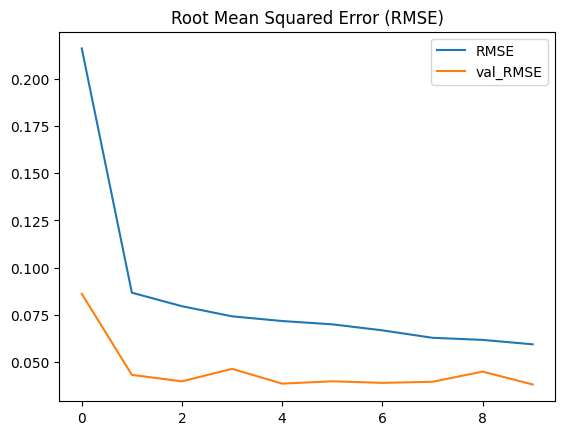

In [182]:
for i in hist:
    print(i[-1].history.keys())
    plt.figure()
    plt.title("Loss")
    plt.plot(np.linspace(0, 9, 10), i[-1].history["loss"], label="loss")
    plt.plot(np.linspace(0, 9, 10), i[-1].history["val_loss"], label="val_loss")
    plt.legend()
    plt.figure()
    plt.title("Root Mean Squared Error (RMSE)")
    plt.plot(np.linspace(0, 9, 10), i[-1].history["root_mean_squared_error"], label="RMSE")
    plt.plot(np.linspace(0, 9, 10), i[-1].history["val_root_mean_squared_error"], label="val_RMSE")
    plt.legend()

<a id="44"></a> <br>
## Choosing the Best Model

In [183]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

0      1      2   3   4    5  \
5  False  False  False  32  32  0.2   
0  False  False  False  16   8  0.2   
1  False  False  False  16  16  0.2   
3  False  False  False  32   8  0.2   
4  False  False  False  32  16  0.2   
2  False  False  False  16  32  0.2   

                                               6  \
5  [0.0014783674851059914, 0.038449544459581375]   
0   [0.0014722474152222276, 0.03836987540125847]   
1  [0.0016360003501176834, 0.040447499603033066]   
3  [0.0014499808894470334, 0.038078613579273224]   
4     [0.0015422138385474682, 0.039271030575037]   
2   [0.0024415338411927223, 0.04941187798976898]   

                                              7  \
5  [0.0019201835384592414, 0.04381990060210228]   
0  [0.0019385135965421796, 0.04402855411171913]   
1  [0.002066322136670351, 0.045456815510988235]   
3   [0.002112259157001972, 0.04595931991934776]   
4  [0.0022449837997555733, 0.04738125950098038]   
2   [0.004099526908248663, 0.06402754783630371]   

                                                   8  
5  <keras.src.callbacks.history.History object at...  
0  <keras.src.callbacks.history.History object at...  
1  <keras.src.callbacks.history.History object at...  
3  <keras.src.callbacks.history.History object at...  
4  <keras.src.callbacks.history.History object at...  
2  <keras.src.callbacks.history.History object at...

<a id="5"></a> <br>
## Results

In [185]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout, history = list(hist.iloc[0, :-2])

In [186]:
print(type(n_neurons))
n_neurons = int(n_neurons)
print(type(n_neurons))

<class 'numpy.int64'>
<class 'int'>


In [187]:
regressor = keras.models.load_model("best_model.keras")
regressor.evaluate(X_test, y_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - root_mean_squared_error: 0.0441  


[0.0019201835384592414, 0.04381990060210228]

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
(891,)
(891,)


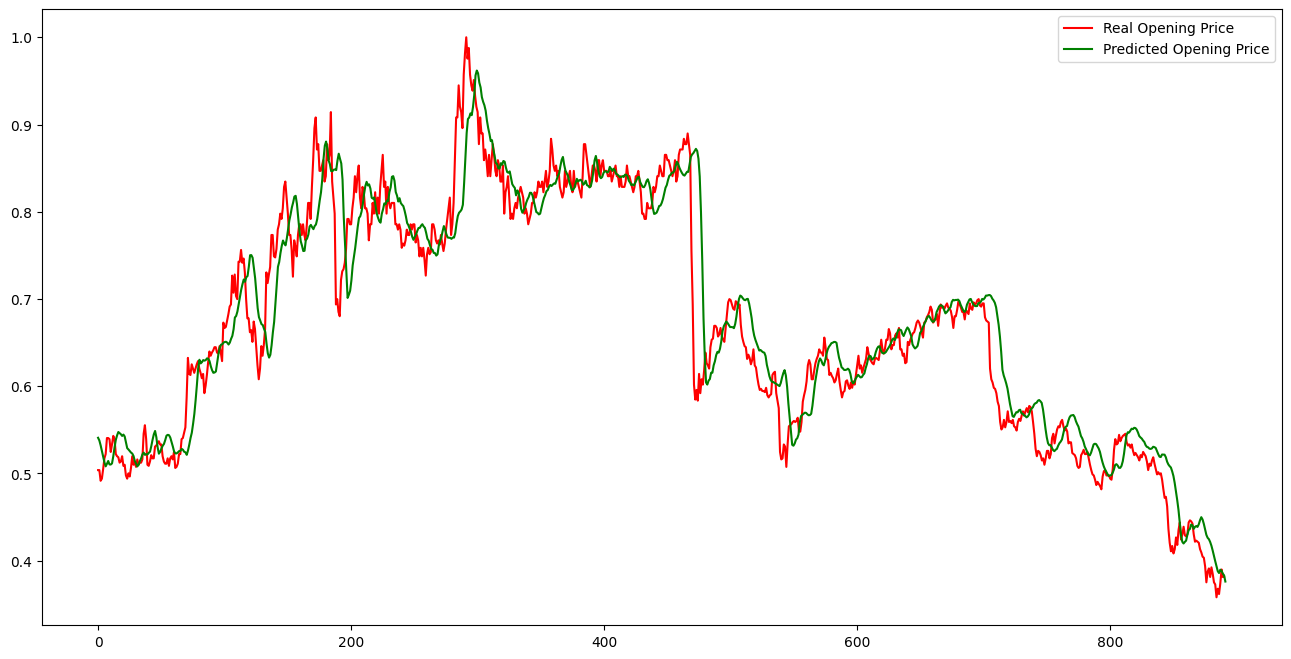

In [188]:
regressor = keras.models.load_model("best_model.keras")
y_pred = regressor.predict(X_test)
print(y_test[:, 0].shape)
print(y_pred[:, 0].shape)
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test[:, 0], color='red', label = 'Real Opening Price')
plt.plot(np.linspace(0, len(y_test[:, 0]), num=len(y_test[:, 0])), y_pred[:, 0], "g", label = 'Predicted Opening Price')
plt.legend(loc='best')

As it is clear in the plot, the trend (rise and fall) of the stock price is well predicted. Nice!

In [189]:
print(y_pred.shape)

(891, 5)


In [190]:
y_pred_new = []
print(y_pred)
for i in range(len(y_pred[0])):
    y_pred_new.append([y_pred[0][i], y_pred[0][i], y_pred[0][i]])
print(y_pred_new)
for i in range(len(y_pred_new)):
    print(sc.inverse_transform(y_pred_new)[i][0])

[[0.54083157 0.54534525 0.53865886 0.54341173 0.5412197 ]
 [0.53774214 0.5422662  0.5355692  0.5403085  0.538116  ]
 [0.5322523  0.53675824 0.53006494 0.53477    0.53255916]
 ...
 [0.38510564 0.39650428 0.38358697 0.38974503 0.38811558]
 [0.3831009  0.39426398 0.38142738 0.3874894  0.38575774]
 [0.37601745 0.38743144 0.37447175 0.38063285 0.37894762]]
[[0.54083157, 0.54083157, 0.54083157], [0.54534525, 0.54534525, 0.54534525], [0.53865886, 0.53865886, 0.53865886], [0.54341173, 0.54341173, 0.54341173], [0.5412197, 0.5412197, 0.5412197]]
81.52413210169506
81.8925243906104
81.34680254003882
81.73471703708888
81.55581129914665


# If you liked my work then please upvote, Thank you.

In [191]:
# Creating a tw_1301 structure (it does not work when you have only one feature)
def create_tw_1301_2(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_tw_1301, y_tw_1301 = [], []
    x_tw_1301.append(df[len(df) - n_past:len(df), 0:n_feature])
    
    return np.array(x_tw_1301)

In [192]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_tw_1301 = create_tw_1301_2(data_scaled, n_future=5, n_past=5, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [193]:
print(X_tw_1301.shape)

(1, 5, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


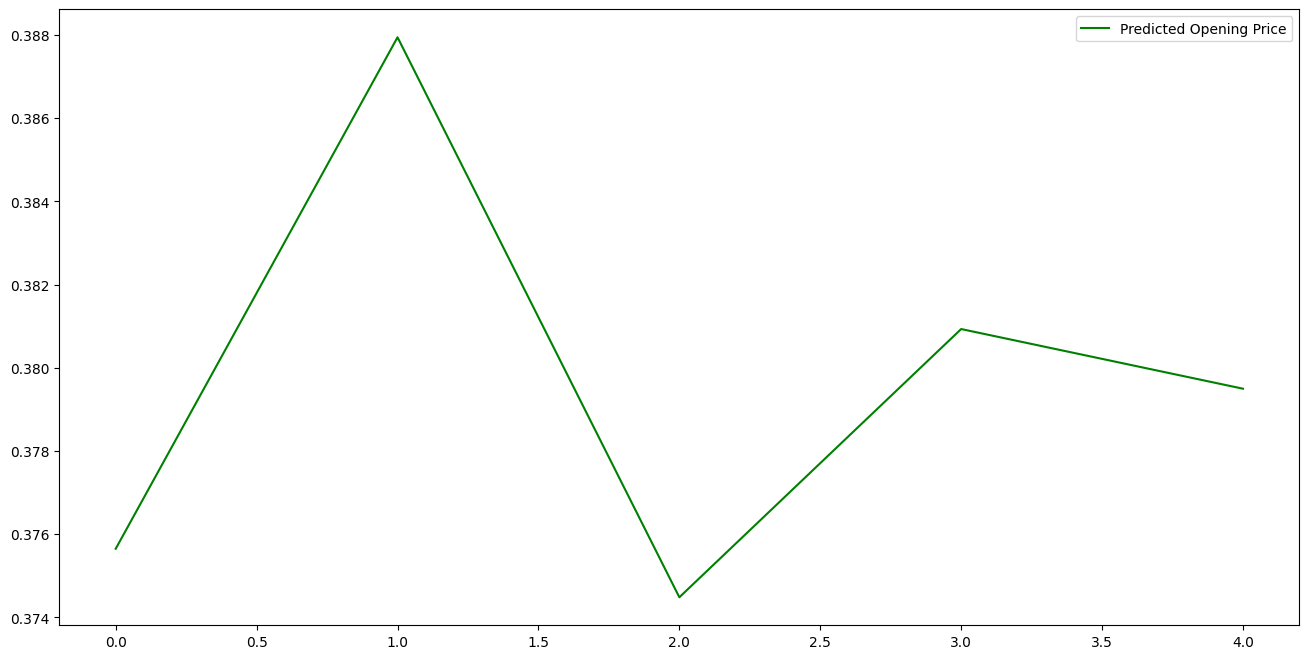

In [194]:
regressor = keras.models.load_model("best_model.keras")
y_pred = regressor.predict(np.expand_dims(X_tw_1301[0], axis=0))

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_pred[0], color="green", label = 'Predicted Opening Price')
plt.legend(loc='best')

In [195]:
print(y_pred.shape)

(1, 5)


[0.37564927, 0.37564927, 0.37564927]
68.04247850550371
69.04611362034446
67.9472657824505
68.473599205282
68.35653649522727
1


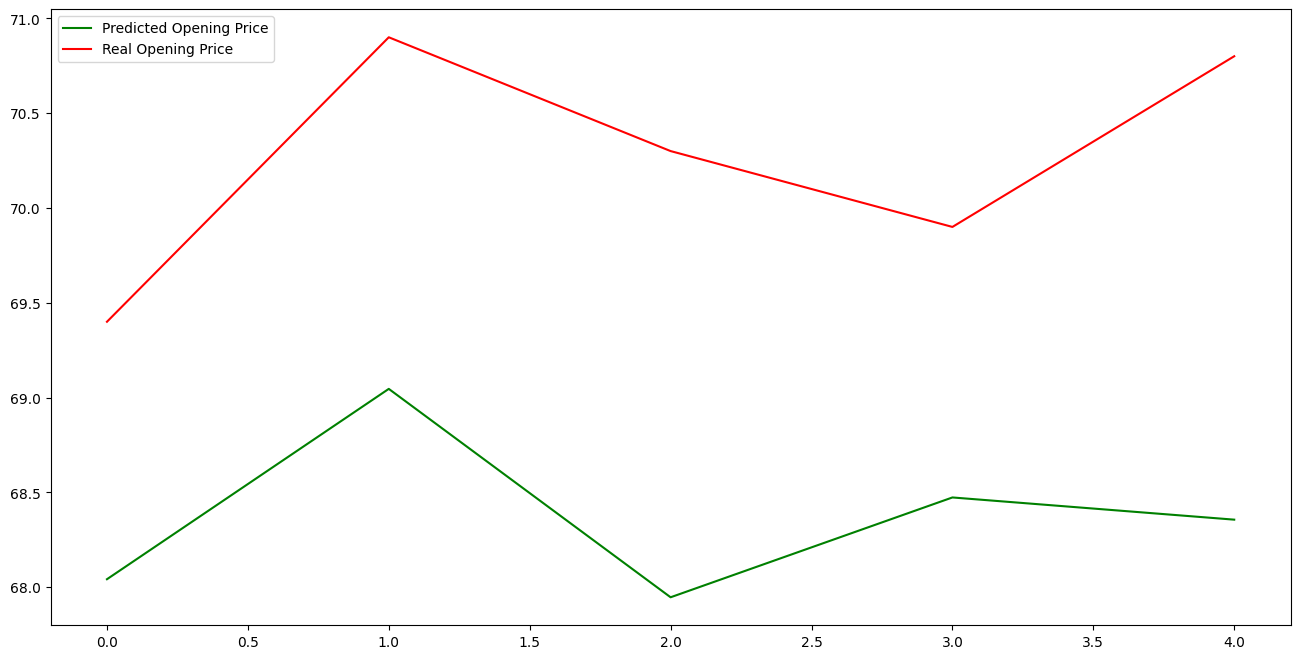

In [196]:
y_pred_new = []
reals = pd.read_csv("1301.TW(驗證).csv").loc[0:4, "Open"]
for i in range(len(y_pred[0])):
    # print(y_pred[i])
    y_pred_new.append([y_pred[0][i], y_pred[0][i], y_pred[0][i]])
print(y_pred_new[0])
for i in range(len(y_pred_new)):
    print(sc.inverse_transform(y_pred_new)[i][0])
print(len(y_pred))
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(sc.inverse_transform(y_pred_new)[:, 0], color="green", label = 'Predicted Opening Price')
plt.plot(reals, color="red", label = 'Real Opening Price')
plt.legend(loc='best')